# Surveillance cameras EDA

Camille Seaberry

## About the datasets

Annotation data was collected from the original data sources (Sheng et al and Objects365), cleaned up on the Roboflow platform, and re-exported in COCO format. I created augmented versions of images to increase the size of the training set by adding randomized small rotations and horizontal flips. There are two datasets here, one of full images possibly containing more than one camera in the frame, and one of images cropped to just the bounding box of a single camera instance.

Note that because of the number of images and their size, for now they're kept out of the github repo. In addition to the training set I analyze here, both datasets also have test and validation splits.

## Housekeeping

In my previous EDA, I used the datasets that I'd cleaned, augmented, and reexported on Roboflow. I've now redownloaded images from their sources in order to focus on the images themselves before looking at the metadata. One issue with this is that the metadata from the Stanford study on Street View images uses panorama IDs; because Google is constantly updating their imagery, these IDs can go out of circulation. I believe this is why I was more recently getting a lot of image downloads coming back blank (just a gray image with an error message on it). I've now removed those images based on their file size (see src/prep_meta.py). Objects365 images are the same.

In [49]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import json
import cv2
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pprint import pprint
import seaborn as sns
import seaborn.objects as so
import warnings

from settings import ROOT_DIR

ROOT_DIR = Path(ROOT_DIR)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
def check_img(path):
    if not path.exists():
        return False
    return True

def safe_read_cv(path):
    # check if path exists
    if check_img(path):
        return cv2.imread(str(path))
    else:
        return np.array([])

In [72]:
# combine street view and vista datasets
sv_meta = pd.read_csv(ROOT_DIR / 'data/streetview/sv_clean.csv')
sv_meta['path'] = sv_meta['image'].apply(lambda x: ROOT_DIR / 'data/streetview/images' / x)
vis_meta = pd.read_csv(ROOT_DIR / 'data/vista/vista_ann.csv')
vis_meta['path'] = vis_meta['image'].apply(lambda x: ROOT_DIR / 'data/vista/images' / x)


svv_meta = pd.concat([sv_meta, vis_meta], axis=0, ignore_index=True)
svv_meta = svv_meta.loc[svv_meta['path'].apply(check_img), :]
# svv_meta['cv'] = svv_meta['path'].apply(safe_read_cv)

with open(ROOT_DIR / 'data/obj365/val-coco.json') as f:
    obj_meta = json.load(f)

In [73]:
svv_meta.head()

,image,xmin,ymin,xmax,ymax,label,path
0,bSaOc101PeC4V2JtGUgmxQ_227.jpg,588.0,214.0,600.0,230.0,0,/home/camille/code/capstone/data/streetview/im...
1,j5EqrxV6yXsyu8YweS_sjA_110.jpg,161.0,298.0,175.0,304.0,1,/home/camille/code/capstone/data/streetview/im...
2,05q_Zxgh4O-zfKTZawzyUw_273.jpg,124.0,111.0,138.0,127.0,0,/home/camille/code/capstone/data/streetview/im...
3,S7Q6lfBn9pNQU4Xx1y8F8g_224.jpg,519.0,136.0,539.0,149.0,1,/home/camille/code/capstone/data/streetview/im...
4,5WGZ65U7ZyQuRCL39Yy-3g_268.jpg,194.0,124.0,207.0,140.0,0,/home/camille/code/capstone/data/streetview/im...


## Analysis of street images

I'm interested in how the images are structured---color, shape, variety. Street images (both Google Street View and Mapillary Vista) in particular have clear patterns by design, with a zoomed out panorama shot of a street that includes the road, sidewalks, buildings, and often a view of the sky, and are generally taken on non-rainy days. The Street View images all come from cities chosen by the Stanford researchers, so they tend to have more gray and beige colors than rural or suburban shots might. Even though the cameras in the Street View images tend to be very small, they're also pretty uniform in color and shape (dark globe or square for the camera, light casing). Mapillary images are much larger, so cameras should  be easier to detect.

### Color

Because these are the types of images I'd like to run inference on, the level of predictability in the structure and colors might be beneficial, because new images will be so reliably similar to the ones the models are trained on. However, this might also have drawbacks: for example, Street View images are taken during the daytime, so a model trained on SV images likely won't perform well at night, and maybe won't do as well in different background (more rural or suburban scenes, indoors, etc).

Here I'm focusing on the Street View images because they form a sort of archetype for inference. With a sample of 500 images, I analyze the distribution of colors across the sample with histograms. Within the RGB space, the distributions are most heavily concentrated around middle values of the three channels, with a spike of strong blue colors (presumably because the sky is shown in many photos). 

To look at this differently, I use k-means clustering to boil the images down to their most dominant color (using k = 1), then view the distribution of those dominant colors, most of which are grays and light blues. This isn't necessarily the average of the images' red, green, and blue components, but the point in color space at which the k-means clustering algorithm picked its center. 

Then I posterize images with k = 3, as a qualitative view of not just the one most dominant color, but the top few. Colors are clustered per image, not across the sample, but because of their similarities they all end up with similar palettes predominantly of beige-gray, light blue, and off white.

In [53]:
def show_cv(img, conv = cv2.COLOR_BGR2RGB, cmap = None, title = None):
    plt.imshow(cv2.cvtColor(img, conv), cmap = cmap)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def img_grid(imgs, 
             nrow = 2, 
             figsize = (10, 10), 
             conv = cv2.COLOR_BGR2RGB, 
             cmap = None, 
             title = None):
    if conv is not None:
        imgs = [cv2.cvtColor(img, conv) for img in imgs]
    # fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = figsize)
    # for i in range(nrow):
    #     for j in range(ncol):
    #         ax[i, j].imshow(imgs[i * ncol + j], cmap = cmap)
    #         ax[i, j].axis('off')
    n = len(imgs)
    ncol = int(np.ceil(n / nrow))
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = figsize)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j < n:
                ax[i, j].imshow(imgs[i * ncol + j], cmap = cmap)
                ax[i, j].axis('off')
    
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    

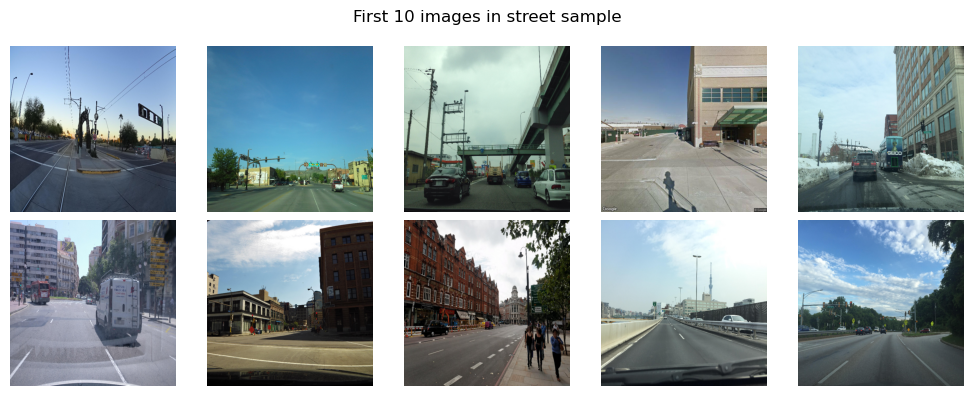

In [84]:
n_samp = 500
svv_samp = svv_meta['path'].sample(n_samp, random_state = 1).apply(safe_read_cv).apply(lambda x: cv2.resize(x, (640, 640)))
img_grid(svv_samp.iloc[0:10], nrow = 2, figsize = (10, 4),
         title = 'First 10 images in street sample')

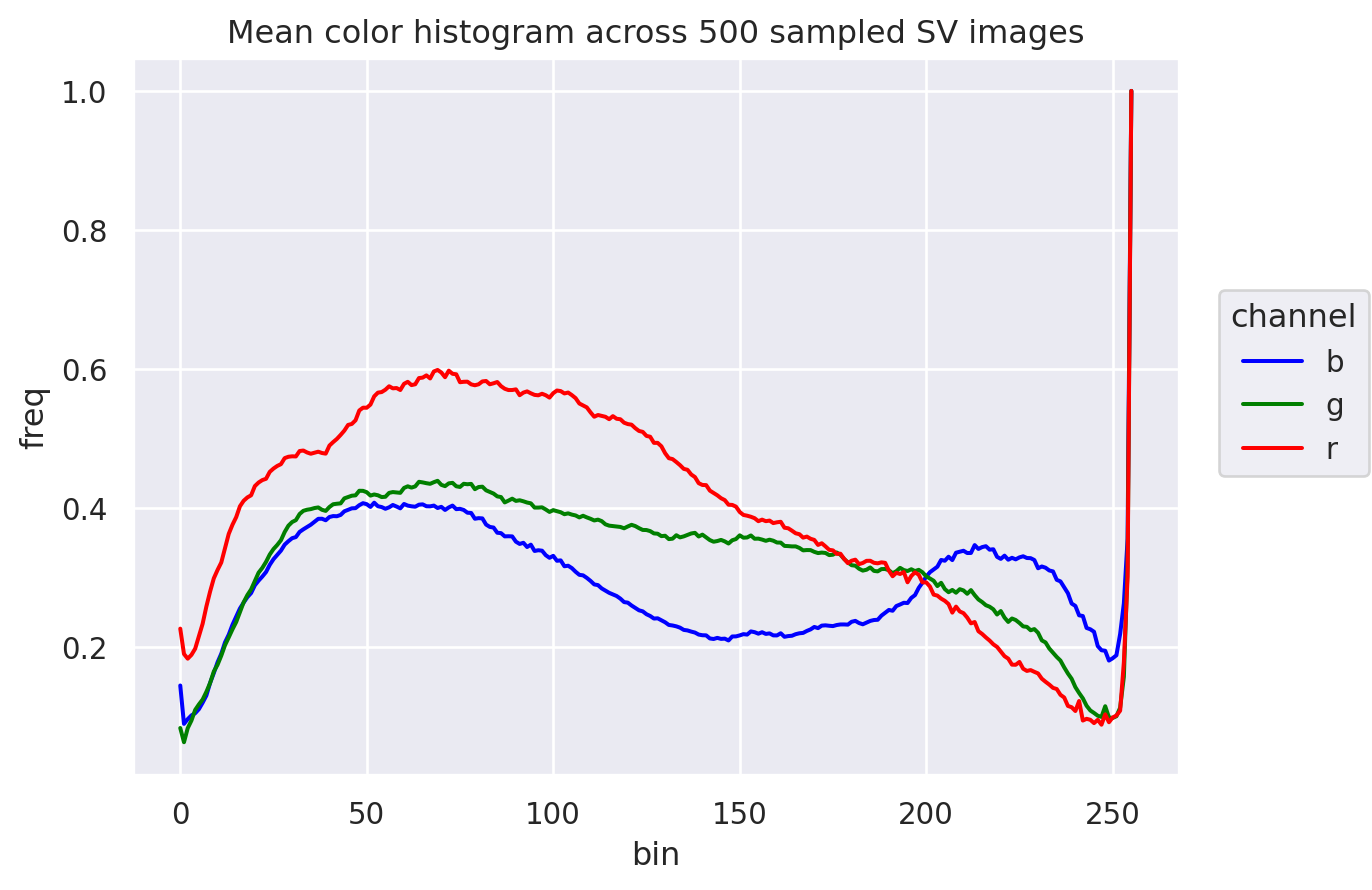

In [85]:
# hists = np.zeros((3, len(sv_samp), 256))
hists = {}
for i, col in enumerate(('b', 'g', 'r')):
    # calcHist returns list of counts at each of 256 bins (each color value)
    hist = np.array([cv2.calcHist([img], 
                                channels = [i],
                                mask = None,
                                histSize = [256],
                                ranges = [0, 256]) for img in svv_samp]).squeeze()
    avg = hist.mean(axis = 0)
    hists[col] = avg / avg.max()

color_hist = pd.DataFrame(hists).reset_index(names = ['bin']) \
    .melt(id_vars = 'bin', var_name = 'channel', value_name = 'freq') 

(
    so.Plot(color_hist, x = 'bin', y = 'freq', color = 'channel')
        .add(so.Line())
        .scale(color = ('blue', 'green', 'red'))
        .label(title = f'Mean color histogram across {n_samp} sampled SV images')
)

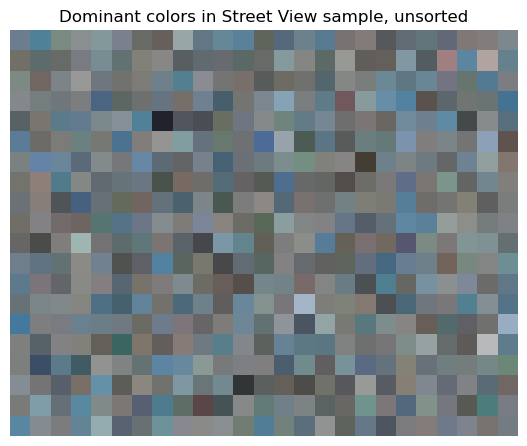

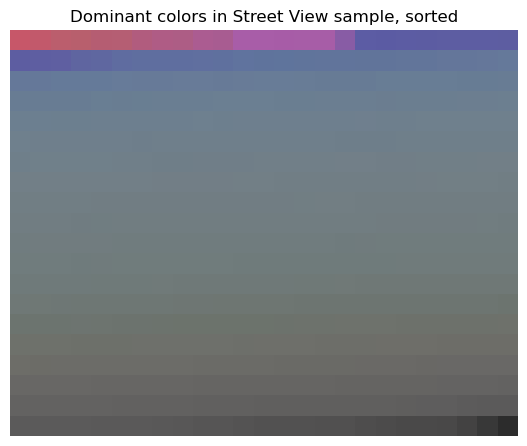

In [86]:
def img_kmeans(img, k = 3):
    ''' 
    Implemetation of kmeans clustering on images based on OpenCV docs
    https://docs.opencv.org/4.8.0/d1/d5c/tutorial_py_kmeans_opencv.html
    '''
    img_float = np.float32(img.reshape((-1, 3)))
    crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, labels, centers = cv2.kmeans(img_float, 
                                      K = k, 
                                      bestLabels = None, 
                                      criteria = crit,
                                      attempts = 10,
                                      flags = cv2.KMEANS_RANDOM_CENTERS)
    # centers = np.uint8([centers])
    centers = np.uint8(centers)
    return centers, labels

def main_hsv(img):
    ''' 
    Using kmeans clustering, get the center of a single cluster to represent the image. 
    This converts to HSV color space in order to easily sort colors by hue and lightness. 
    '''
    center, _ = img_kmeans(img, k = 1)
    hsv = cv2.cvtColor(np.array([center]), cv2.COLOR_BGR2HSV)
    return hsv.flatten()

def posterize(img, k = 3):
    centers, labels = img_kmeans(img, k = k)
    result = centers[labels.flatten()].reshape(img.shape)
    return result
    

main_hsv(svv_samp.iloc[0])

img_colors = np.array([main_hsv(img) for img in svv_samp])
show_cv(img_colors.reshape((20, 25, 3)), 
        conv = cv2.COLOR_HSV2RGB, 
        title = 'Dominant colors in Street View sample, unsorted')

# sort img_colors in reverse
img_colors.sort(axis = 0)
img_colors = img_colors[::-1]
show_cv(img_colors.reshape((20, 25, 3)), 
        conv = cv2.COLOR_HSV2RGB, 
        title = 'Dominant colors in Street View sample, sorted')

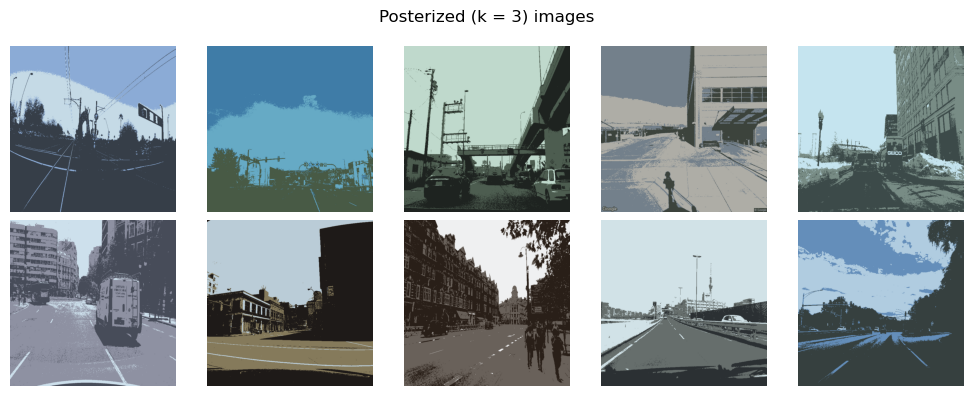

In [87]:
np.random.seed(0)
poster_imgs = np.array([posterize(img) for img in svv_samp.iloc[0:10]])
img_grid(poster_imgs, figsize = (10, 4), title = 'Posterized (k = 3) images')

### Shape

Next I'm interested in the structure of the image scenes. I use principal components analysis (PCA) to reduce grayscale versions of the images to fewer dimensions and mimic the eigenfaces used in facial recognition exercises. The first few components create rather spooky street scenes, with elements that hint at roads, curbs, crosswalks (striping pattern in the forefront), building and windows, shapes that might be overpasses or darker skies, and parked cars. They also retain the Google watermark in the bottom left corner. The captured PCs can then be used to reconstruct images.

While this helps with understanding the image composition overall, because the cameras are so small I don't think this will be a very useful technique in camera detection.

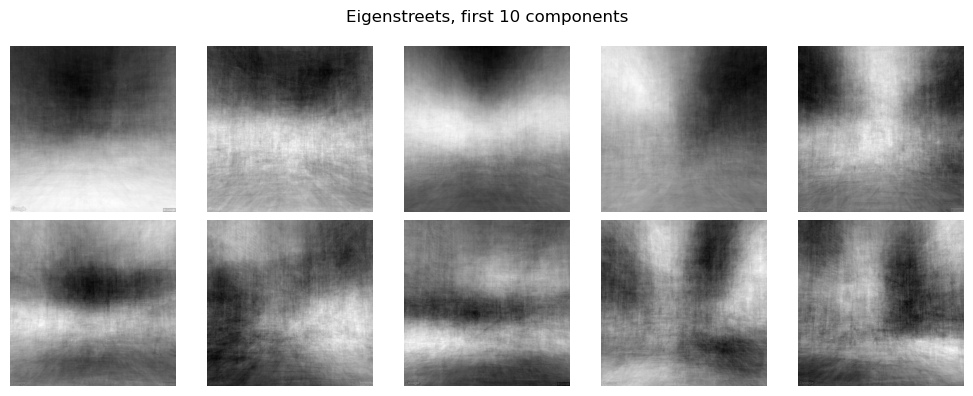

In [88]:
scaler = StandardScaler(with_mean = True, with_std = True)

imgs_flat = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in svv_samp])
imgs_scale = scaler.fit_transform(imgs_flat)
n_comps = 20
pca = PCA(n_components = n_comps, whiten = True, random_state = 0)
pca.fit(imgs_scale)
eigenstreets = pca.components_.reshape((n_comps, 640, 640))
img_pca = pca.transform(imgs_flat)

img_grid(eigenstreets[0:10],
         nrow = 2, figsize = (10, 4), conv = None, cmap = 'gray', 
         title = 'Eigenstreets, first 10 components')

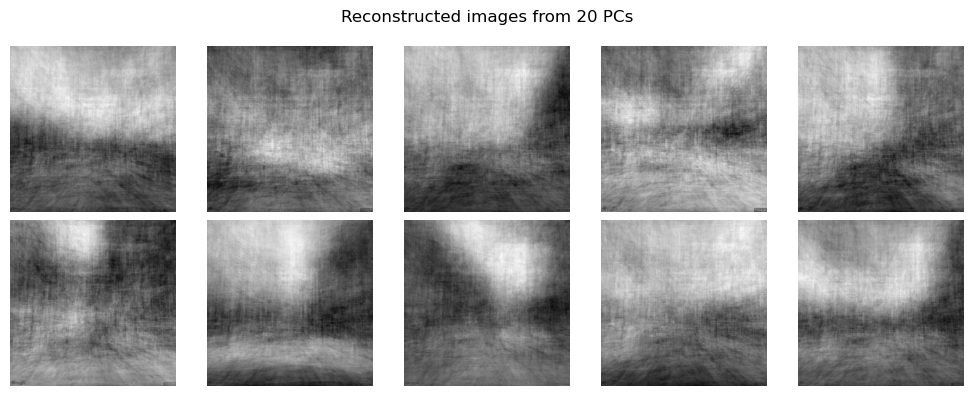

In [89]:
recon = pca.inverse_transform(img_pca)
img_grid(recon.reshape((500, 640, 640))[0:10],
         nrow = 2, figsize = (10, 4), conv = None, cmap = 'gray',
         title = f'Reconstructed images from {n_comps} PCs')

### Feature mapping 

As a more advanced version of the eigenstreets, I am also curious as to how the images might decompose using simple neural networks. I'll be using more complex pretrained models for object detection later, but for feature mapping a multilayer perceptron will suffice. However, for EDA I'm just trying this out with scikit-learn training a very weak MLP without using my GPU, which yields features similar to the eigenstreets. It's a bit artificial, since for the full size images I don't expect to be doing classification anyway, and only trained on this sample of 500 images without augmentation.

In [90]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import minmax_scale

In [91]:
# label_samp = sv_meta.iloc[sv_samp.index, :]['label']
label_samp = [1 for i in range(n_samp)]
hidden_layers = (64,)
mlp = MLPClassifier(hidden_layer_sizes = hidden_layers,
                    # solver = 'lbfgs',
                    # activation = 'relu',
                    random_state = 1,
                    max_iter = 20)
mlp.fit(imgs_scale, label_samp)

MLPClassifier(hidden_layer_sizes=(64,), max_iter=20, random_state=1)

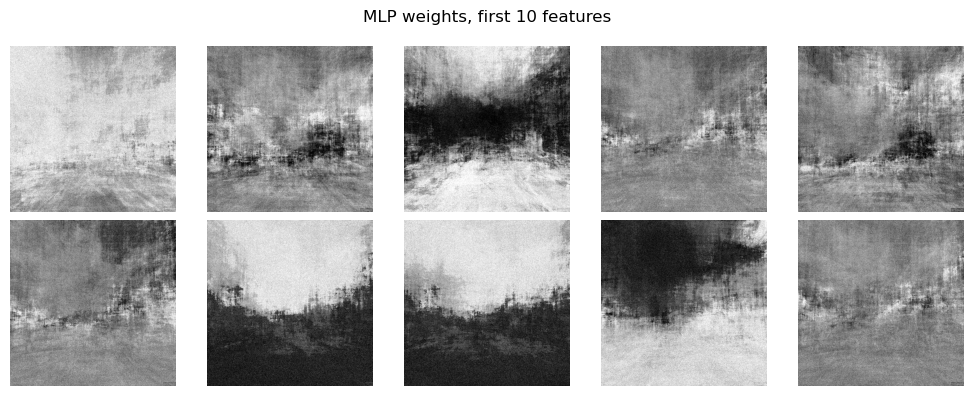

In [92]:
mlp_wts = minmax_scale(mlp.coefs_[0].T)
mlp_shape = (hidden_layers[0], 640, 640)
img_grid(mlp_wts.reshape(mlp_shape)[0:10], nrow = 2, conv = None, figsize = (10, 4), cmap = 'gray',
         title = 'MLP weights, first 10 features')

## Reassembly & EDA with combined datasets

For the rest of this EDA, I'm working with the recombined training set (both Street View and Objects365). I've reuploaded the images from both sources to Roboflow and created training, validation, and testing sets with augmentations to increase the number of training samples. Compared to my previous project, there are fewer images now because of the Street View images that are no longer available. Both datasets (full-sized images for object detection, cropped images for classification) are then re-exported in COCO format.

Previously, the augmentations I used were only randomized rotations and horizontal flipping. Because of my exploration of the color distribution in Street View images, I will add augmentations to create more variation in hue and saturation. However, I'm trying YOLO for object detection, which recommends not augmenting separate from their training script, so for now I am leaving augmentation to the training process.

I am dropping observations with extremely small areas (below 8 square pixels) from the classification data. Before augmentation, this accounts for 73 cropped images.

### Metadata

Beyond the data encoded in images, much of the information about the dataset comes from the annotations. For full-sized images (detection task), these are in COCO JSON format; for cropped (classification task) these are in folders by class. This will allow both to be read easily by Pytorch. Any images without bounding boxes were removed automatically by Roboflow, so there are no missing annotations. Because there can be more than one observation in an image, the number of annotations is greater than the number of images.

For classification, across all splits there are about even numbers of globe and directed cameras.

In [21]:
def count_by_dir(path: Path):
    ''' 
    Count number of files by directory, returning parent directory as well
    '''
    imgs = path.glob('**/*.jpg')
    parents = set([img.parent for img in imgs])
    counts = {}
    for parent in parents:
        counts[str(parent.stem)] = len(list(parent.glob('*.jpg')))
    return counts
    

In [23]:
meta_full = {}
n_ann_full = {}
n_img_full = {}
n_class_crop = {}
for split in ['train', 'test', 'valid']:
    # full images are annotated in coco file
    full_path = ROOT_DIR / 'data/cams_full_coco' / split / '_annotations.coco.json'
    with open(full_path) as f:
        meta_full[split] = json.load(f)
    
    # count annotations
    n_ann_full[split] = len(meta_full[split]['annotations'])
    # count images
    n_img_full[split] = len(meta_full[split]['images'])
    
    # cropped images are organized by folder
    crop_path = ROOT_DIR / 'data/cams_crop' / split
    n_class_crop[split] = count_by_dir(crop_path)

print('number of full-size images by split:')
pprint(n_img_full, sort_dicts = False)

print('\nnumber of full-size annotations by split:')
pprint(n_ann_full, sort_dicts = False)

print('\nnumber of cropped images by split and class:')
pprint(n_class_crop, sort_dicts = False)

print(f'\nkeys in full image metadata: { meta_full["train"].keys() }')
print('\nexample of annotations for a single image:')
pprint(meta_full['train']['annotations'][0])

print('\nexample of metadata for a single image:')
pprint(meta_full['train']['images'][0])
    

number of full-size images by split:
{'train': 866, 'test': 133, 'valid': 226}

number of full-size annotations by split:
{'train': 1549, 'test': 242, 'valid': 490}

number of cropped images by split and class:
{'train': {'globe': 267, 'directed': 289},
 'test': {'globe': 32, 'directed': 47},
 'valid': {'globe': 84, 'directed': 75}}

keys in full image metadata: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

example of annotations for a single image:
{'area': 222,
 'bbox': [365, 73, 12, 18.5],
 'category_id': 1,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}

example of metadata for a single image:
{'date_captured': '2023-10-29T02:40:09+00:00',
 'file_name': 'objects365_v1_00438773_jpg.rf.2391ae716c005fcd46463a2f7568dac0.jpg',
 'height': 640,
 'id': 0,
 'license': 1,
 'width': 640}


In [24]:
for key, val in meta_full.items():
    anns = val['annotations']
    # consider missing if no bbox
    is_missing = [len(ann['bbox']) == 0 for ann in anns]
    print(f'{key}: missing {sum(is_missing)} bboxes')


train: missing 0 bboxes
test: missing 0 bboxes
valid: missing 0 bboxes


EDA that follows will be on training data only. Street View images are downloaded at a uniform 640 x 640 pixels, but because camera bounding boxes can be different sizes, and are often very, very small, cropped images will have a variety of dimensions. 

Image metadata contains:

* A unique image ID
* A flag for a license (these were uploaded under CC BY 4.0), same for all images
* File name
* Height & width, same for all columns
* Date & time of upload
* Extra notes (all empty)

In [25]:
img_df = pd.DataFrame(meta_full['train']['images'])
img_df.head()

,id,license,file_name,height,width,date_captured,extra
0,0,1,objects365_v1_00438773_jpg.rf.2391ae716c005fcd...,640,640,2023-10-29T02:40:09+00:00,NaN
1,1,1,aSkzPWd1ibB_zxyv0OgtYQ_24_jpg.rf.1fbaf9ab5263a...,640,640,2023-10-29T02:40:09+00:00,NaN
2,2,1,mFYROhkqQ8a9EQcKEsJlJA_177_jpg.rf.24eb916fd6ee...,640,640,2023-10-29T02:40:09+00:00,NaN
3,3,1,NfVwNHVQmXh6z__527TKbQ_15_jpg.rf.2056237d8d2a2...,640,640,2023-10-29T02:40:09+00:00,NaN
4,4,1,objects365_v1_00335353_jpg.rf.21398401833b4368...,640,640,2023-10-29T02:40:09+00:00,NaN


In [26]:
img_df.describe()

,id,license,height,width
count,866.000000,866.0,866.0,866.0
mean,432.500000,1.0,640.0,640.0
std,250.136962,0.0,0.0,0.0
min,0.000000,1.0,640.0,640.0
25%,216.250000,1.0,640.0,640.0
50%,432.500000,1.0,640.0,640.0
75%,648.750000,1.0,640.0,640.0
max,865.000000,1.0,640.0,640.0



Since this isn't a segmentation task, segmentation points are empty, as is the flag for whether the image contains a crowd. Additionally, annotations contain:

* A unique annotation ID
* An image ID for joining annotations to images
* Category ID (1 = directed, 2 = globe, 3 = unclassified (Objects365 images))
* Bounding box as a list of coordinates (center x, y; width, height)
* Area of bounding box

In [65]:
ann_df = pd.DataFrame(meta_full['train']['annotations'])
print(ann_df.describe())
ann_df['width'] = ann_df['bbox'].apply(lambda x: x[2])
ann_df['height'] = ann_df['bbox'].apply(lambda x: x[3])
ann_df['aspect'] = ann_df['width'] / ann_df['height']
ann_df = ann_df.loc[ann_df['area'] >= 8, :]

                id     image_id  category_id          area  iscrowd
count  1549.000000  1549.000000       1549.0   1549.000000   1549.0
mean    774.000000   431.235636          1.0    323.428825      0.0
std     447.302098   253.209755          0.0   1908.787023      0.0
min       0.000000     0.000000          1.0      1.000000      0.0
25%     387.000000   212.000000          1.0     36.000000      0.0
50%     774.000000   406.000000          1.0     82.500000      0.0
75%    1161.000000   661.000000          1.0    189.000000      0.0
max    1548.000000   865.000000          1.0  54002.000000      0.0


In [66]:
ann_df.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd,width,height,aspect
0,0,0,1,"[365, 73, 12, 18.5]",222.0,[],0,12.0,18.5,0.648649
1,1,0,1,"[375, 7, 62.5, 80]",5000.0,[],0,62.5,80.0,0.781250
2,2,1,1,"[423, 287, 5, 5]",25.0,[],0,5.0,5.0,1.000000
3,3,2,1,"[403, 64, 12, 18]",216.0,[],0,12.0,18.0,0.666667
4,4,3,1,"[303, 248, 28, 9]",252.0,[],0,28.0,9.0,3.111111


For more accurate object detection, I've dropped classes from the full images (only class is surveillance camera, not type). Observationally, one difference between directed and globe cameras is directed cameras tend to be wider across and shorter vertically, with a greater width-to-height ratio and greater total area, while globe cameras are closer to square. Both are extremely small, however: classifying 10 x 10 images will be difficult.

The vast majority of images have only 1 or 2 cameras marked in them. Some  have upwards of 15; checking for anomalies, it does seem realistic for some indoor scenes from the Objects365 data to have many cameras. For example, the highest number of annotations in an image is 25; this occurs 3 times, but all are augmentations of one image. (This has changed some as I've reshuffled the data.) As shown below, this is a shot of the checkout area of a big box store, so it makes sense that so many cameras would be in close proximity. If there were more of these extreme values I might filter some out, since this is a situation that's unlikely for the Street View images I want to use for inference, but this few observations shouldn't be enough to throw off the training.

In [67]:
# pd.merge(ann_df, img_df, left_on = 'image_id', right_on = 'id', how = 'left')
anns_x_img = pd.merge(
    ann_df.loc[:, ['image_id', 'category_id']],
    img_df.loc[:, ['id']],
    left_on = 'image_id',
    right_on = 'id',
    how = 'left'
).rename(columns = {'id': 'ann_id'})
anns_x_img['n_per_img'] = 1
anns_x_img = anns_x_img.groupby('image_id').agg({ 'n_per_img': 'sum'})
anns_x_img.describe()

,n_per_img
count,866.000000
mean,1.704388
std,1.703557
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,17.000000


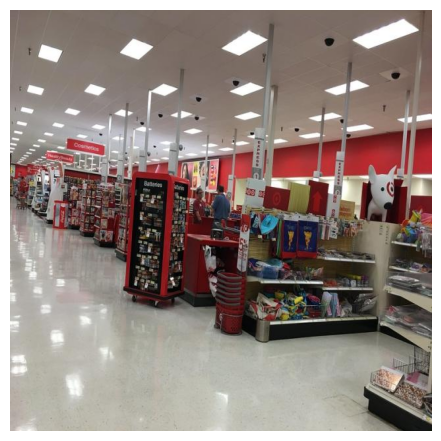

In [76]:
many_cams = anns_x_img.loc[anns_x_img['n_per_img'] > 15, :].index
# many_cam_ex = img_df.iloc[many_cams[0], :]['file_name']
# show_cv(cv2.imread(str(ROOT_DIR / 'data/cams_full/train' / many_cam_ex)))
many_cam_ex = img_df.iloc[many_cams, :]['file_name'].values[0]
show_cv(cv2.imread(str(ROOT_DIR / 'data/cams_full/train/images' / many_cam_ex)))

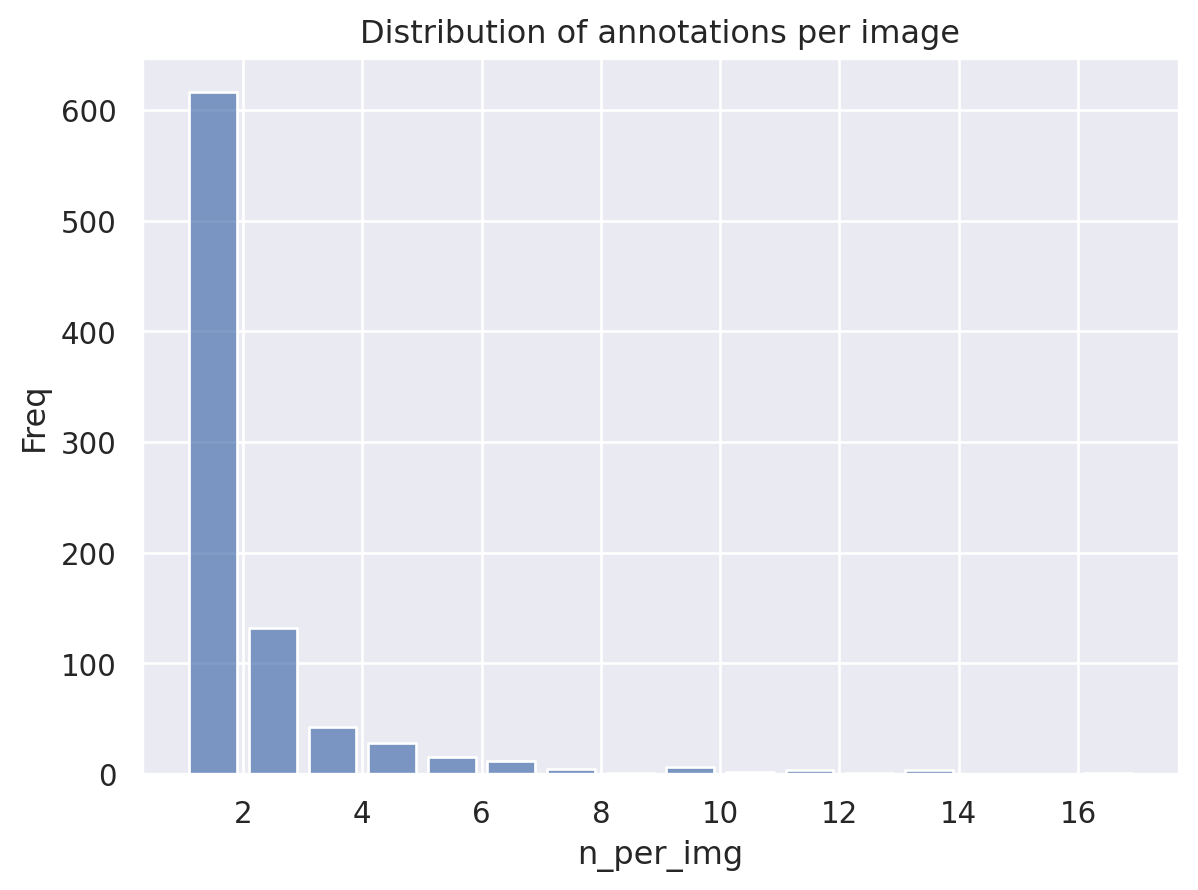

In [69]:
(
    so.Plot(anns_x_img, x = 'n_per_img')
        .add(so.Bars(width = 0.8), so.Hist(binwidth = 1))
        .label(title = 'Distribution of annotations per image', y = 'Freq')
)

Finally, a sample of some of the cropped images:

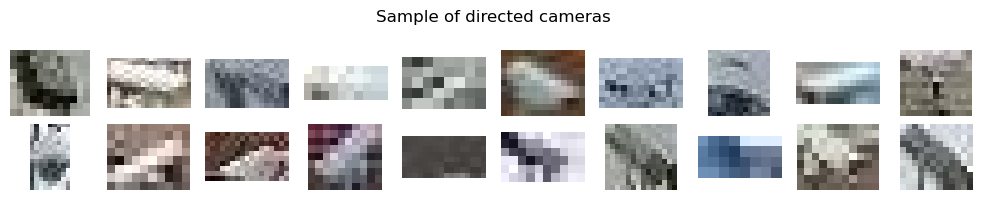

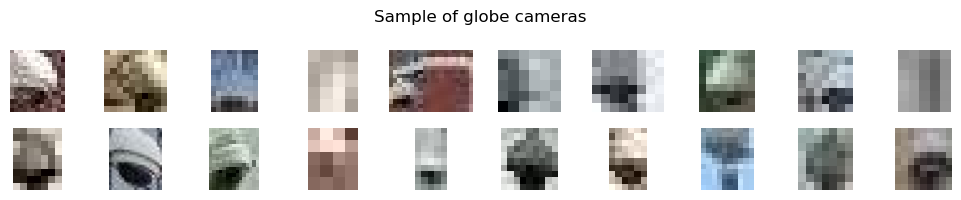

In [101]:
def sample_crop(n = 50, split = 'train'):
    crop_dir = ROOT_DIR / 'data/cams_crop' / split  
    dirs = crop_dir.glob('*')
    samp_by_class = {}
    for cls in dirs:
        img_paths = list(cls.glob('*.jpg'))
        samp = np.random.choice(img_paths, size = n, replace = False)
        samp_paths = [str(img) for img in samp]
        samp_by_class[str(cls.stem)] = pd.DataFrame(samp_paths, columns = ['path'])
    samp_df = pd.concat(samp_by_class, axis = 0, names = ['category']).reset_index(level = 0)
    samp_df['cv'] = samp_df['path'].apply(lambda x: cv2.imread(x))
    return samp_df

np.random.seed(0)
crop_samp = sample_crop(n = 250)
crop_samp['height'] = crop_samp['cv'].apply(lambda x: x.shape[0])
crop_samp['width'] = crop_samp['cv'].apply(lambda x: x.shape[1])
crop_samp['area'] = (crop_samp['height'] * crop_samp['width']).astype('float')
crop_samp['aspect'] = crop_samp['width'] / crop_samp['height']

# img_grid(crop_samp.iloc[0:20, :]['cv'])
img_grid(crop_samp.loc[crop_samp['category'] == 'directed', 'cv'][0:20], 
         nrow = 2, figsize = (10, 2), title = 'Sample of directed cameras')

img_grid(crop_samp.loc[crop_samp['category'] == 'globe', 'cv'][0:20], 
         nrow = 2, figsize = (10, 2), title = 'Sample of globe cameras')


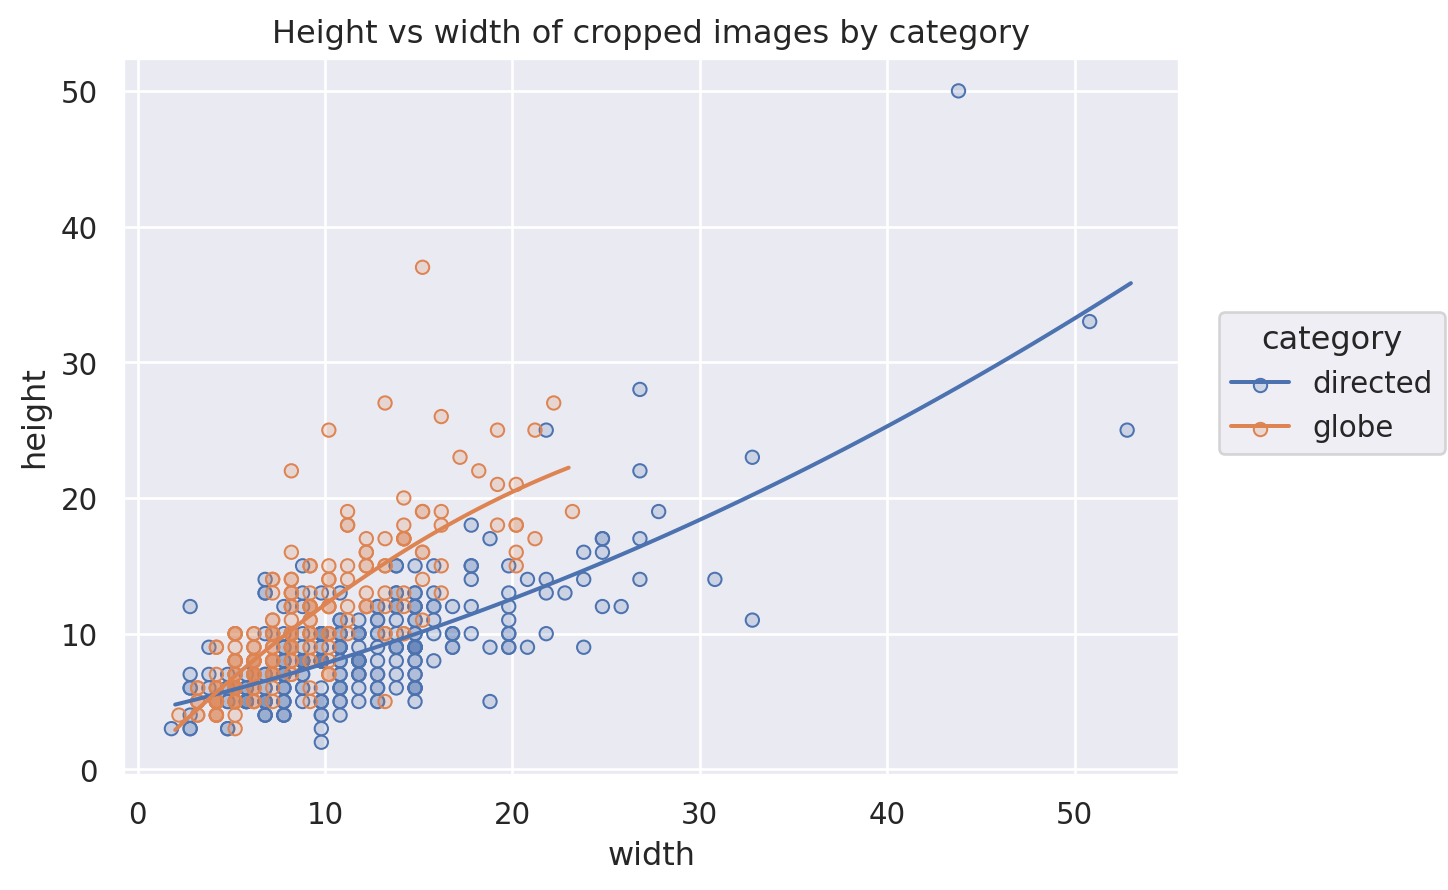

In [102]:
(
    so.Plot(crop_samp, x = 'width', y = 'height', color = 'category')
        .add(so.Dots(pointsize = 5), so.Dodge())
        .add(so.Line(), so.PolyFit())
        .label(title = 'Height vs width of cropped images by category')
)

While I'll be using deep learning for both object detection and classification, the bounding boxes seem like they might be varied enough by category to use simpler machine learning techniques to build a reasonable classifier. For example, with no tuning, both naive bayes and random forest classifiers perform fairly well.

In [125]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# scaler = StandardScaler(with_mean = True, with_std = True)
nb = GaussianNB()
rf = RandomForestClassifier()
X = crop_samp.loc[:, ['width', 'height', 'area', 'aspect']]
y = crop_samp['category']
nb.fit(X, y)
rf.fit(X, y)
print(f'naive bayes classifier score: {nb.score(X, y)}')
print(f'random forest classifier score: {rf.score(X, y)}')

naive bayes classifier score: 0.728
random forest classifier score: 0.872
